# Final Report

## Data

In the project, I use data on couples in Austria which comes from several sources:
* Birth registry (1990-2007)
* Divorce / marriage register until 2007
* Wage income data

I completed the project as a part of my Master's Thesis on the effect of the trend of women getting higher levels of education and how it affects the couples' dynamics.

In total, it is a 5% sample (~34k couples). A couple is operationalized as a female and a male who gave birth to the first child (in other words, they are 'linked' by their first child). Therefore, there is no information on a couple's duration since the couple's breakup is not defined. The couple does not imply marriage (in fact, as we will see, more than 40% of the couples are not married, at least, to the other parent).

The **variables** provided to me are:
* Sex
* Age
* Salaries 2 years before the birth
* Education (compulsory school, apprenticeship, middle or high school, university or college)
* Family status (single, married, married to other person, divorced)
* Municipality as the child's birthplace (not used in the analysis, left for the future step
* Year of the child's birth
* Year of marriage if it happened

In the analysis, I did not use the last three variables, which were left for the future iterations of work towards the thesis.

### Packages

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns

### Data Preparation for Exploratory Data Analysis

In [40]:
data_original = pd.read_csv("microdata.csv")
data_eda = data_original.copy()

data = pd.DataFrame()
data['family_status'] = data_original['gr_m_family_status'].copy()
data.loc[data['family_status']!=2, 'family_status']=1
data['family_status'] = data['family_status'] - 1

# Dropping out variables not used in the analysis
data_eda.drop(columns=['Unnamed: 0', 'c_birth_date', 'marr_date', 'gr_m_community'], inplace=True)

for col in ['gr_m_family_status', 'm_edu4', 'f_edu4', 'edu4_comp']:
    data_eda[col] = pd.Categorical(data_eda[col])

# NB: '_m_' in the variables stands for mother and '_f_' for father since the relationships
#   are defined by the parenthood

## Exploratory Data Analysis

In [3]:
data_eda.describe()

,m_age_at_birth,f_age_at_birth,m_annual_salary_tm2,f_annual_salary_tm2,c_birth_year
count,32234.000000,30048.000000,32230.000000,30043.000000,32234.000000
mean,26.066110,29.232994,13025.175232,15986.812664,1998.275579
std,5.077912,6.141691,10397.020006,12935.825221,5.205613
min,14.000000,14.000000,0.000000,0.000000,1990.000000
25%,22.000000,25.000000,3929.285095,3766.359985,1994.000000
50%,26.000000,29.000000,12527.424805,15542.679688,1998.000000
75%,29.000000,33.000000,19739.487793,24615.714844,2003.000000
max,46.000000,69.000000,85272.406250,75627.320312,2007.000000


### Counts of categorical variables

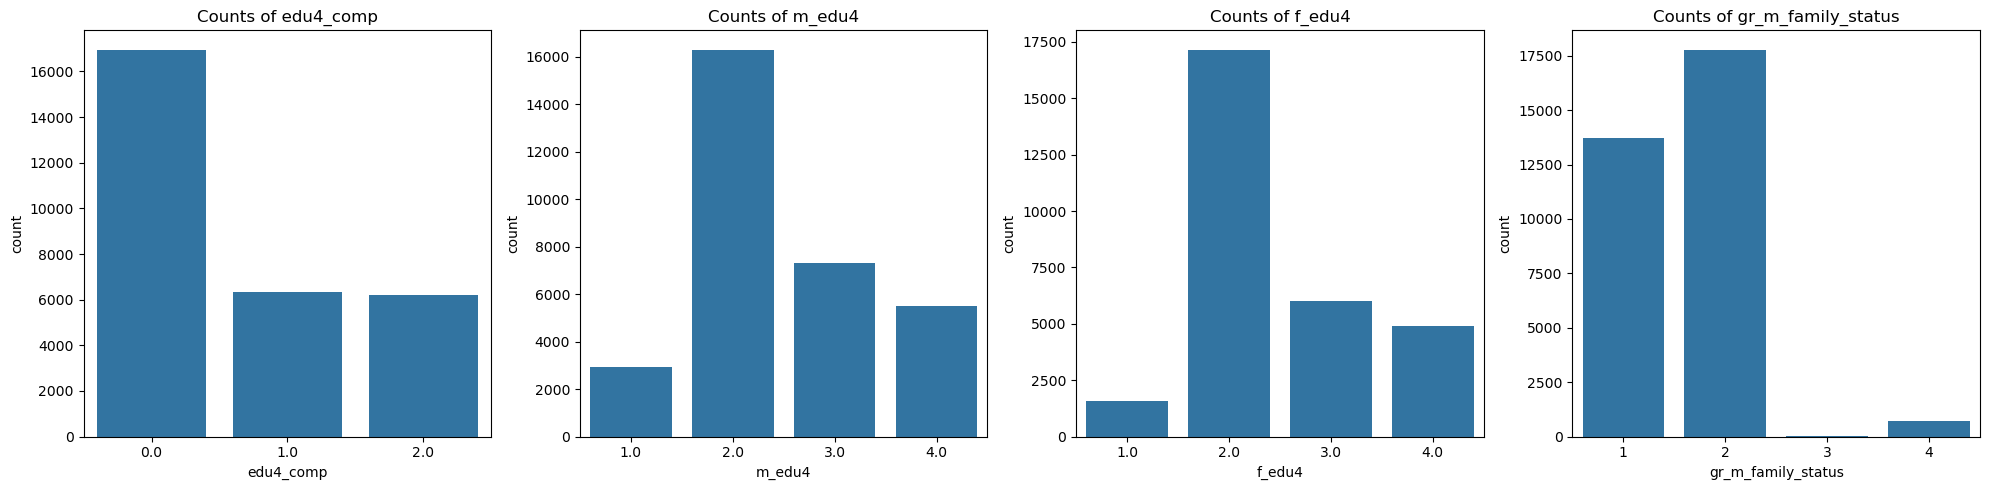

In [4]:
categorical_columns = set()

for column in data_eda:
    if data_eda[column].dtype=='category':
        categorical_columns.add(column)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=data_eda, ax=axs[i])
    axs[i].set_title(f'Counts of {column}')

plt.tight_layout()
plt.show()

The first three variables have a strange order in the dataset. Most importantly, the first one is actually symmetrical because 1 means that a male achieved higher education level than a female in a couple, 0 is when they are equal, 2 is when a female is more educated.
The last variable of family status has very few couples for which a female is married to another person (3) or divorced (4) at the time of birth. I decided to disregard those categories and consider those individuals as not married (to each other) to make the variable binary (non-married/married).

### Pairwise distributions of continuous variables

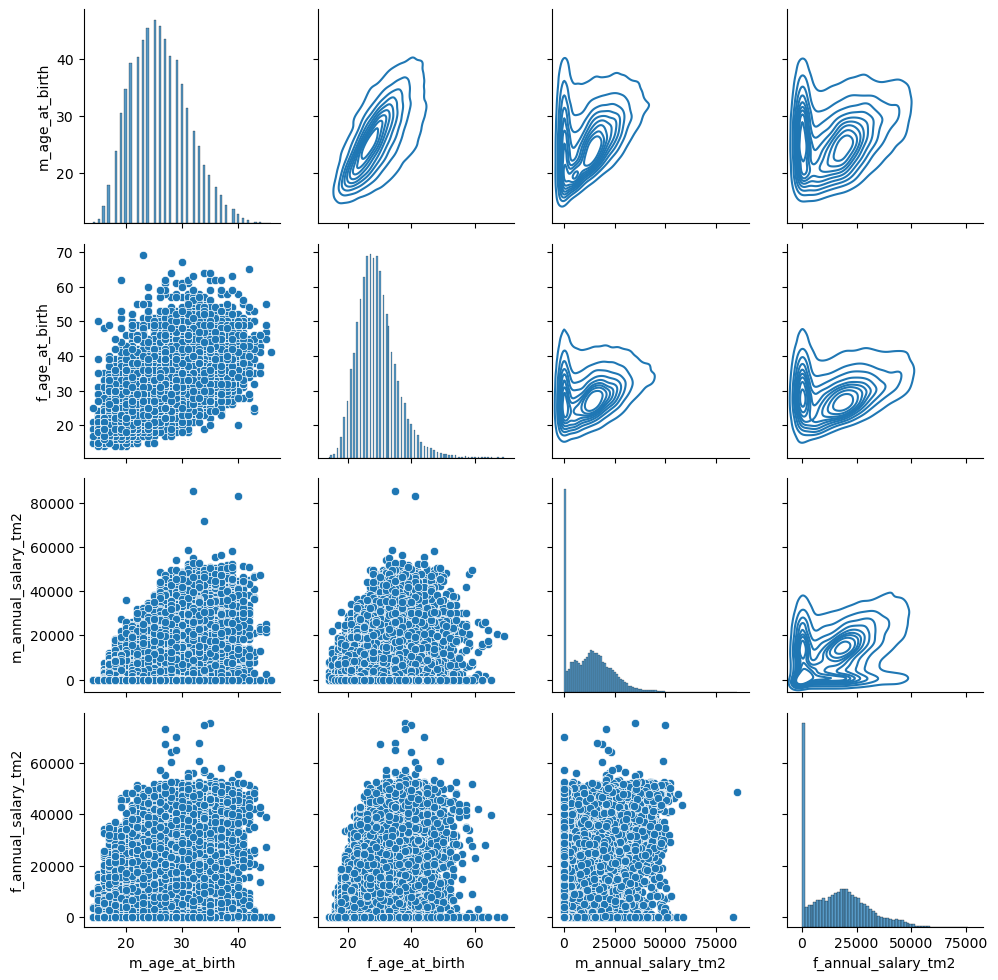

In [41]:
g = sns.PairGrid(data_eda, diag_sharey=False)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

Ages of the parents at birth are distributed quite normally, this is almost the case for salaries as well except that they are zero-deflated. 

### Creating couple-level variables for modelling

Since the response variable is on couples, I aggregated the individual-level data so that the new variables represent the differences between partners.

For education, I used the variable `edu4_comp` from the initial dataset. I changed it to a more intuitive order, so that values of 0 are when a male achieved higher formal education (M>F), 1 for M=F, and 2 for M<F.

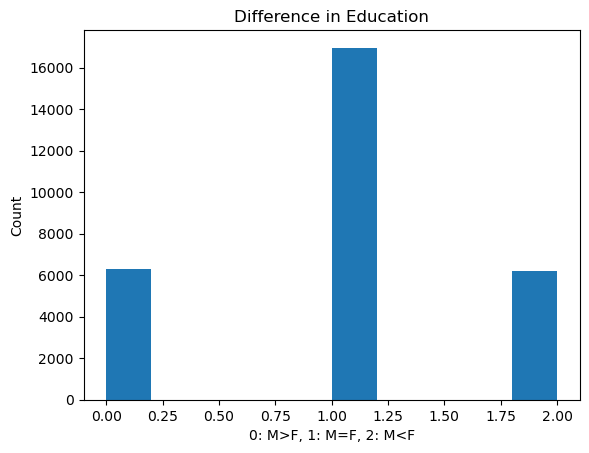

In [5]:
data['education_difference'] = data_original['edu4_comp'].replace({0: 1, 1: 0, 2: 2})

# 0:  male education > female education, 1: equal, 2: male education < female education
plt.title('Difference in Education')
plt.xlabel('0: M>F, 1: M=F, 2: M<F')
plt.ylabel('Count')
plt.hist(data['education_difference']);

For the salaries, I combined them into a share of a woman's salary in the total family budget, so 0.5 means equality, if it is < 0.5 then a male partner has higher salary and vice versa. Here, I also made a strong assumption about salaries of 0 by considering them non-existing rather than actually being equal to 0. The reason is that in Austria, people receive quite a generous allowance when they do not work (including ones with some types of residence permit), or may support their life through other means, so salary of 0 is rather an exception.

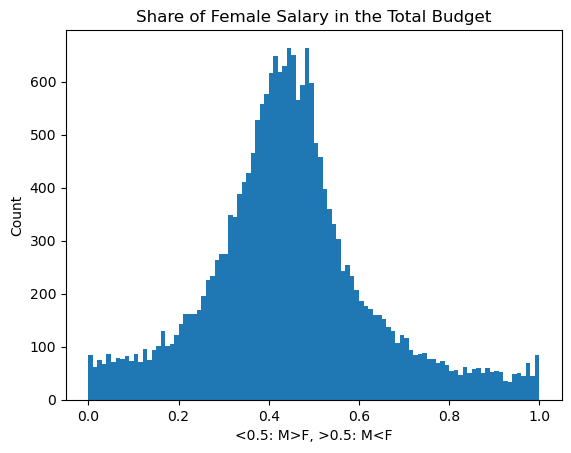

In [6]:
data['salary_difference'] = np.nan

for i, row in data_original.iterrows():
    if np.isnan(row['m_annual_salary_tm2']) or np.isnan(row['f_annual_salary_tm2']) \
        or row['m_annual_salary_tm2'] == 0 or row['f_annual_salary_tm2'] == 0:
        data.loc[i, 'salary_difference'] = np.nan
    else:
        data.loc[i, 'salary_difference'] = row['m_annual_salary_tm2'] / (row['m_annual_salary_tm2'] + row['f_annual_salary_tm2'])

plt.title('Share of Female Salary in the Total Budget')
plt.xlabel('<0.5: M>F, >0.5: M<F')
plt.ylabel('Count')
plt.hist(data['salary_difference'], bins=100);

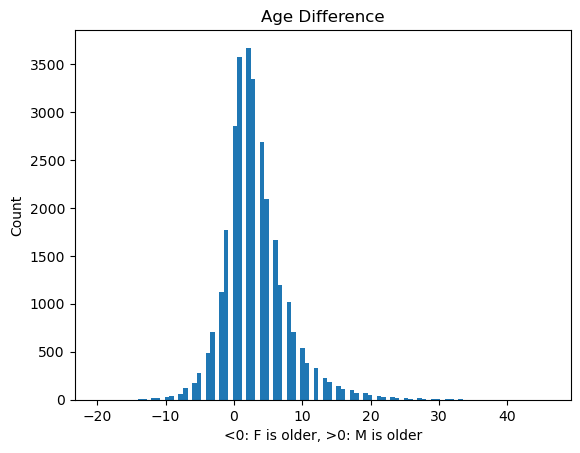

In [7]:
data['age_difference'] = data_original['f_age_at_birth'] - data_original['m_age_at_birth']

plt.title('Age Difference')
plt.xlabel('<0: F is older, >0: M is older')
plt.ylabel('Count')
plt.hist(data['age_difference'], bins=100);

## The analysis

In the analysis, I compare three generalized linear models:
* *marital_status* ~ *age_difference*
* *marital_status* ~ *age_difference* + *salary_difference*
* *marital_status* ~ *age_difference* + *salary_difference* + *education_difference*

### *marital_status* ~ *age_difference*

With the first model, I managed to make PyMC work. A nice feature of the package is that it is possible to outsorce imputation of missing data since PyMC automatically achieves it by sampling from the posterior distribution during the MCMC.

In [8]:
with pm.Model() as model:
    # priors
    b = pm.Normal("b", mu=0, sigma=1)

    age_difference = pm.Normal('age_difference', mu=0.5, sigma=0.5, observed=data['age_difference'])
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    # linear model
    mu = intercept + age_difference * b
    # link function
    p = pm.math.invlogit(mu)
    # likelihood
    family_status = pm.Bernoulli("family_status", p=p, observed=data['family_status'])

/opt/anaconda3/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in age_difference contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


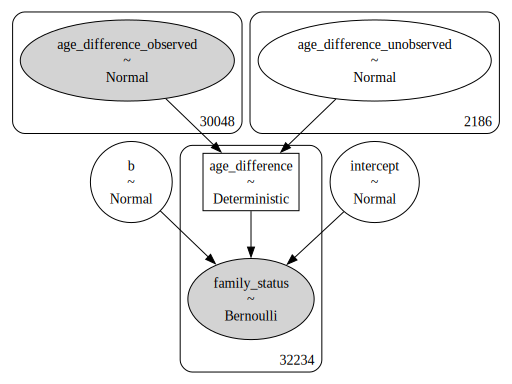

In [9]:
pm.model_to_graphviz(model)

In [10]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, age_difference_unobserved, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

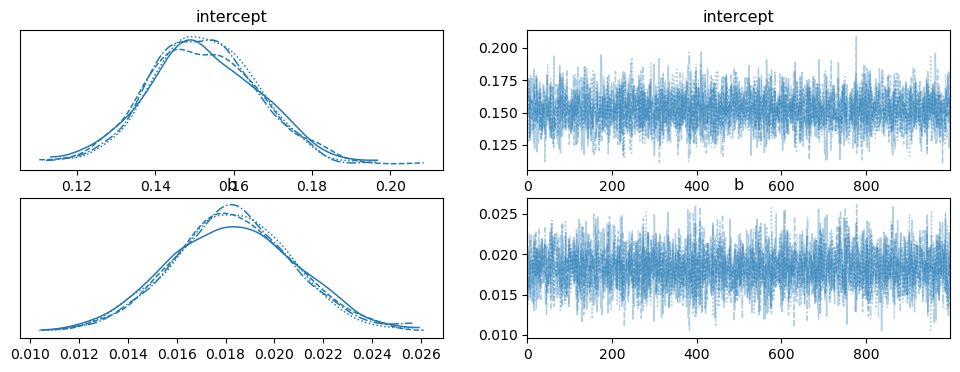

In [11]:
az.plot_trace(trace, var_names=['intercept', 'b'], compact=True)

In [12]:
model_a = bmb.Model('family_status ~ age_difference',
                    family='bernoulli',
                    link='logit',
                    data=data.dropna())

results_a = model_a.fit()

Modeling the probability that family_status==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age_difference]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


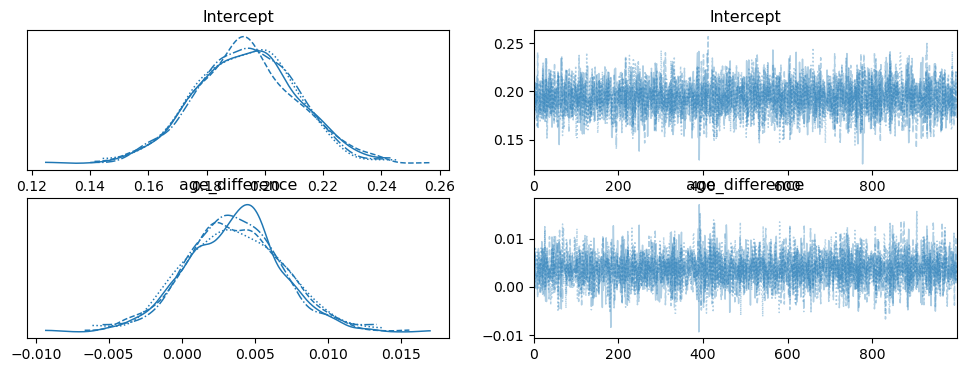

In [13]:
az.plot_trace(results_a, figsize=(18, 12));

In [26]:
az.summary(results_a)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.193,0.017,0.161,0.225,0.0,0.0,4171.0,2840.0,1.0
age_difference,0.004,0.003,-0.002,0.010,0.0,0.0,4127.0,2864.0,1.0


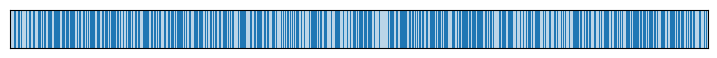

In [27]:
model_a.predict(results_a, kind="pps")
az.plot_separation(results_a, y='family_status', figsize=(9,0.5));

### *marital_status* ~ *age_difference* + *salary_difference*

In [15]:
model_b = bmb.Model('family_status ~ age_difference + salary_difference',
                    family='bernoulli',
                    link='logit',
                    data=data.dropna())

results_b = model_b.fit()

Modeling the probability that family_status==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age_difference, salary_difference]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 680 seconds.


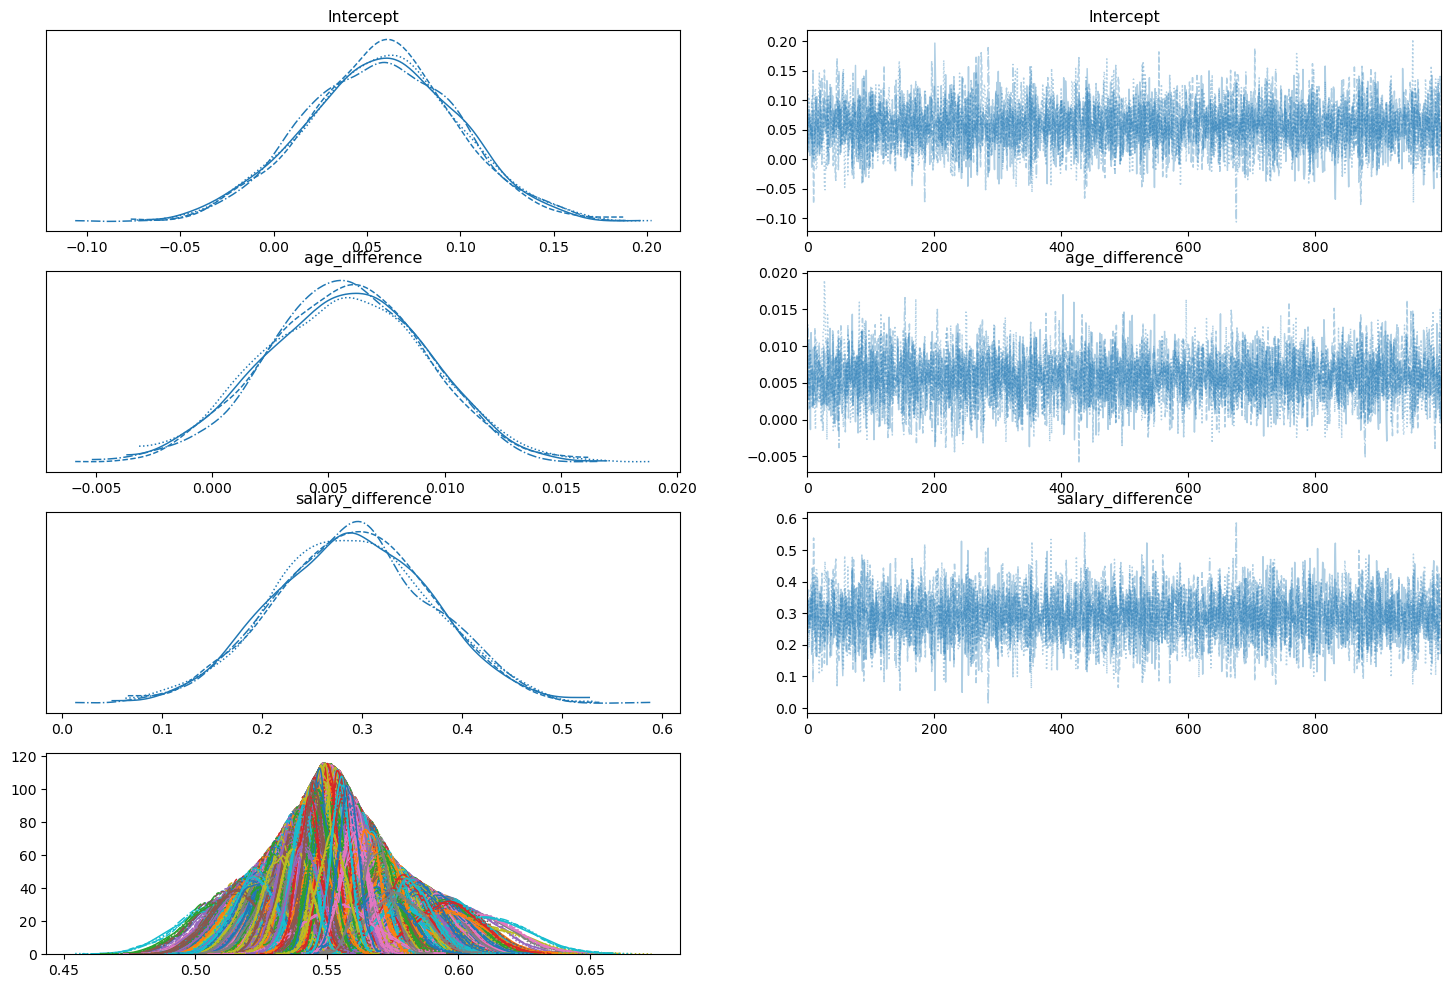

In [43]:
az.plot_trace(results_b, figsize=(18, 12));

In [17]:
az.summary(results_b)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.057,0.041,-0.022,0.132,0.001,0.000,6474.0,2851.0,1.0
age_difference,0.006,0.003,-0.001,0.012,0.000,0.000,6022.0,3453.0,1.0
salary_difference,0.291,0.078,0.149,0.441,0.001,0.001,6210.0,3056.0,1.0


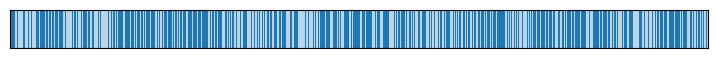

In [25]:
model_b.predict(results_b, kind="pps") # Posterior Predictive Sampling
az.plot_separation(results_b, y='family_status', figsize=(9,0.5));

### *marital_status* ~ *age_difference* + *salary_difference* + *education_difference*

In [18]:
model_c = bmb.Model('family_status ~ age_difference + salary_difference + education_difference',
                    family='bernoulli',
                    link='logit',
                    data=data.dropna())

results_c = model_c.fit()

Modeling the probability that family_status==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age_difference, salary_difference, education_difference]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 721 seconds.


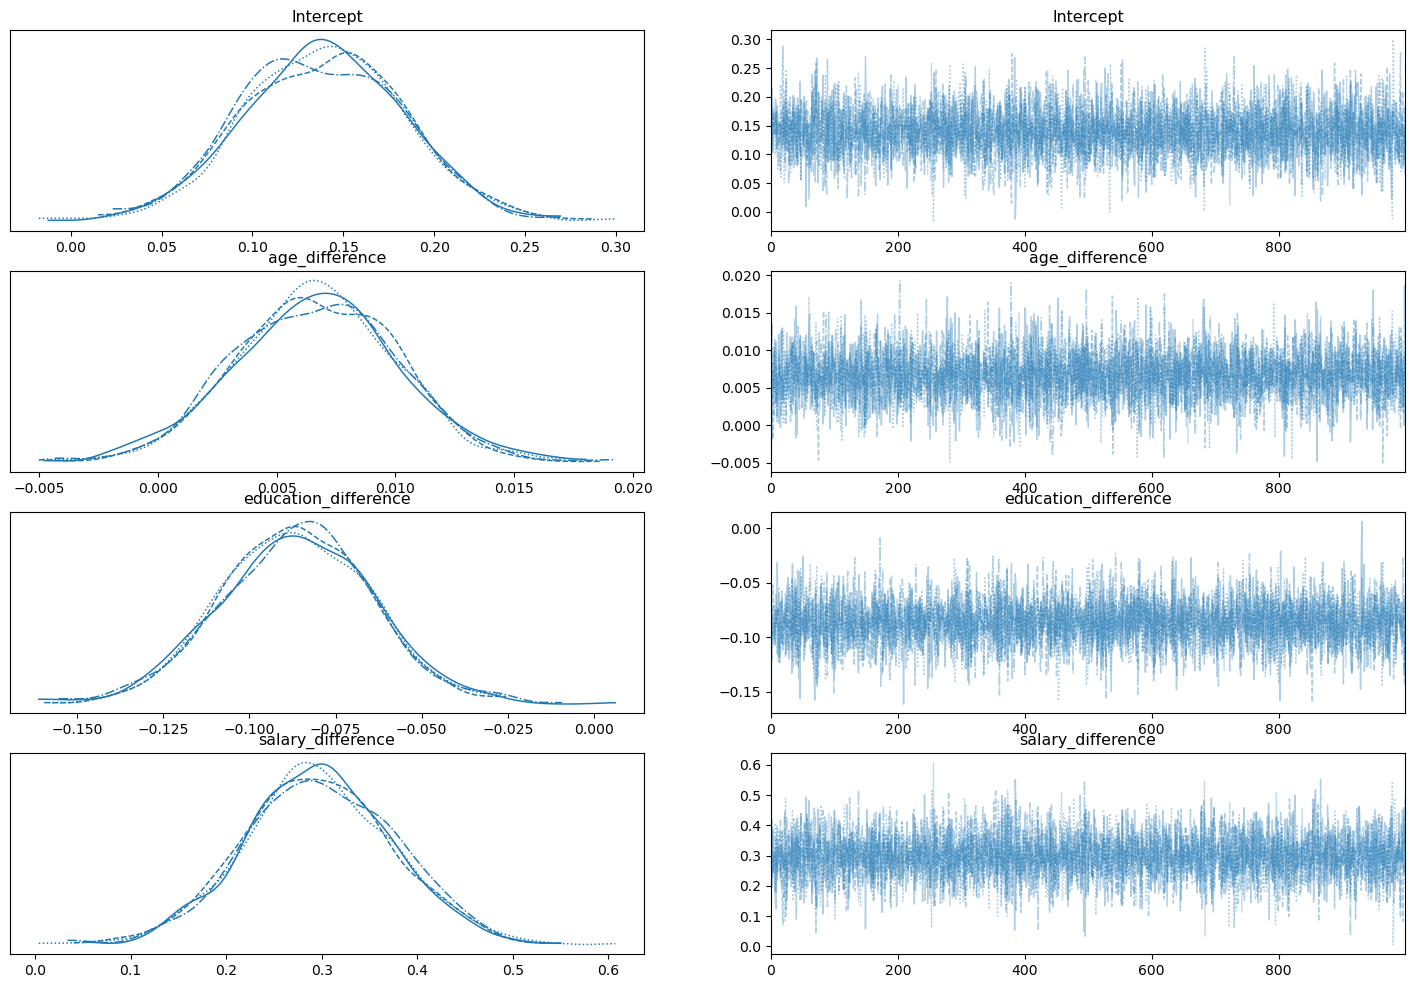

In [22]:
az.plot_trace(results_c, figsize=(18,12));

In [20]:
az.summary(results_c)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.139,0.044,0.059,0.223,0.001,0.000,5938.0,3302.0,1.0
age_difference,0.007,0.003,-0.000,0.013,0.000,0.000,6752.0,3051.0,1.0
education_difference,-0.087,0.022,-0.125,-0.044,0.000,0.000,6008.0,3333.0,1.0
salary_difference,0.297,0.078,0.146,0.441,0.001,0.001,6397.0,3326.0,1.0


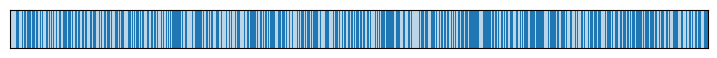

In [24]:
model_c.predict(results_c, kind="pps")
az.plot_separation(results_c, y='family_status', figsize=(9,0.5));

## Conclusion

The models did not seem to perform well likely because the aggregation of the variables discarded important information about the differences. Plus, the models were simplistic and did not incorporate the variables of time and space.

## Future work

1. To analyse first municipalities and then mating markets. The plot below (created by my advisor Erich Striessnig) shows the change in squeeze indicator (which is a bit more advanced indicator of women with tertiary education / men with tertiary education withing a population).

![](images/squeeze_1981_2020_40km_matura_age25_max1.5.jpg)

2. To account for the differences between cohorts (both within a couple and between the couples).

3. To improve my math skills.